<a href="https://colab.research.google.com/github/smannan/grape-disease-classification/blob/master/grape_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib

In [56]:
# set up access to Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read in the data

In [64]:
# unzip the dataset
#import shutil
#shutil.rmtree('/content/grape-disease-data')
!unzip -q '/content/drive/My Drive/CMPE257/grape-disease-data.zip'

replace grape-disease-data/esca_measles/grapes_esca_measles_28.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [0]:
# read the class labels
data_dir = pathlib.Path('/content/grape-disease-data')
disease_labels = os.listdir(data_dir)

In [7]:
disease_labels

['black_rot',
 'esca_measles',
 'healthy',
 'powder_downey',
 'leaf_blight',
 'phylloxera']

In [8]:
# print number of images
NUM_IMAGES = len(list(data_dir.glob('*/*.jpeg')))
print ('Found {0} images for processing'.format(NUM_IMAGES))

Found 1110 images for processing


In [9]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != ".DS_Store"])
print (CLASS_NAMES)

['black_rot' 'esca_measles' 'healthy' 'powder_downey' 'leaf_blight'
 'phylloxera']


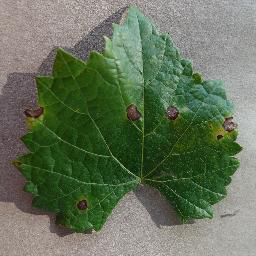

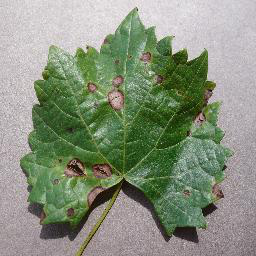

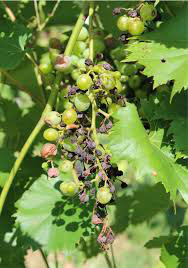

In [10]:
# look at a few raw input data
black_rot = list(data_dir.glob('black_rot/*'))
for image_path in black_rot[:3]:
  display.display(Image.open(str(image_path)))

# Define methods for creating the train, validation, and test sets


1.   Scale pixel values between 0-1
2.   Resize images for model
3.   Create tuples of image vector, label for tensorflow



In [0]:
# parameters for the images
BATCH_SIZE = 32
IMG_HEIGHT = 160
IMG_WIDTH = 160
STEPS_PER_EPOCH = np.ceil(NUM_IMAGES/BATCH_SIZE)

In [0]:
# for viewing a batch of images
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [0]:
# create a tensorflow dataset from the files
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [14]:
for f in list_ds.take(5):
  print(f.numpy())

b'/content/grape-disease-data/phylloxera/phyllo10202321111.jpeg'
b'/content/grape-disease-data/healthy/0b2ed0b4-a6e1-4fb3-82dc-47f903f3d0a9___JR_HL 9603.jpeg'
b'/content/grape-disease-data/black_rot/black_rot76.jpeg'
b'/content/grape-disease-data/healthy/0ce12a10-c6ff-494e-a927-5ddc809c707a___Mt.N.V_HL 8945.jpeg'
b'/content/grape-disease-data/black_rot/black_rot185.jpeg'


In [0]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # centrally crop image to 75% of its extents
  # img = tf.image.central_crop(img, 0.75)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [0]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

# Split full dataset into training, validation, and testing


1.   70% train : 777 images
2.   15% validation: 167 images
3.   15% test: 166 images



In [0]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE

# split data into train, test, validation
train_size = int(0.7 * NUM_IMAGES)
val_size = int(0.15 * NUM_IMAGES)
test_size = int(0.15 * NUM_IMAGES)

full_dataset = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
full_dataset.shuffle

train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

In [19]:
for image, label in train_dataset.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (160, 160, 3)
Label:  [False  True False False False False]


In [0]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = val_dataset.batch(BATCH_SIZE)
test_batches = test_dataset.batch(BATCH_SIZE)

In [21]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 160, 160, 3])

# Define the model


1.   Keep the Inception Resnet model frozen
2.   Add an average pooling layer
3.   And a dense, fully-connected softmax activation layer



In [22]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

# Create the base model from the pre-trained model InceptionResNetV2 V2
base_model = tf.keras.applications.InceptionResNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

219062272/219055592 [==============================] - 2s 0us/step


In [23]:
# get one batch of features to train
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 1536)


In [0]:
# freeze the base model so its weights are not updated during training
base_model.trainable = False

In [26]:
# convert features to a single vector per image
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1536)


In [27]:
# add a final layer to get predictions for 6 classes, sigmoid activation for multiclass
prediction_layer = tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 6)


In [0]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [0]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='kullback_leibler_divergence',
              metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 3, 3, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 9222      
Total params: 54,345,958
Trainable params: 9,222
Non-trainable params: 54,336,736
_________________________________________________________________


In [31]:
# only weights and biases are trainable
len(model.trainable_variables)

2

# Train the model

1.   Use kullback_leibler_divergence loss over 20 epochs
2.   ~89% validation accuracy



In [39]:
initial_epochs = 20
validation_steps = 20

loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

 6/20 [========>.....................] - 7s 1s/step - loss: 0.6679 - accuracy: 0.7545


In [40]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.67
initial accuracy: 0.75


In [41]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/20
25/25 [==============================] - 52s 2s/step - loss: 0.6465 - accuracy: 0.7761 - val_loss: 0.5273 - val_accuracy: 0.8144
Epoch 2/20
25/25 [==============================] - 51s 2s/step - loss: 0.6330 - accuracy: 0.7864 - val_loss: 0.5745 - val_accuracy: 0.8204
Epoch 3/20
25/25 [==============================] - 52s 2s/step - loss: 0.5964 - accuracy: 0.8031 - val_loss: 0.5797 - val_accuracy: 0.8204
Epoch 4/20
25/25 [==============================] - 52s 2s/step - loss: 0.6157 - accuracy: 0.8082 - val_loss: 0.5886 - val_accuracy: 0.8323
Epoch 5/20
25/25 [==============================] - 52s 2s/step - loss: 0.6003 - accuracy: 0.8134 - val_loss: 0.5651 - val_accuracy: 0.8383
Epoch 6/20
25/25 [==============================] - 53s 2s/step - loss: 0.5904 - accuracy: 0.8057 - val_loss: 0.5414 - val_accuracy: 0.8024
Epoch 7/20
25/25 [==============================] - 57s 2s/step - loss: 0.5929 - accuracy: 0.7992 - val_loss: 0.5428 - val_accuracy: 0.8144
Epoch 8/20
25/25 [==

In [0]:
def plot_accuracy(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

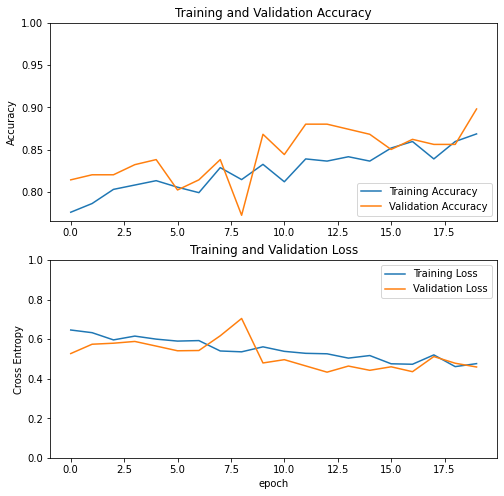

In [43]:
plot_accuracy(history)

# Fine-tune the model by unfreezing the top layers

In [0]:
base_model.trainable = True

In [45]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  780


In [0]:
# compile the model with a lower learning rate
model.compile(loss='kullback_leibler_divergence',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 3, 3, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 9222      
Total params: 54,345,958
Trainable params: 53,517,846
Non-trainable params: 828,112
_________________________________________________________________


In [50]:
len(model.trainable_variables)

426

In [51]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

Epoch 20/30
25/25 [==============================] - 177s 7s/step - loss: 1.3952 - accuracy: 0.5135 - val_loss: 0.3204 - val_accuracy: 0.8982
Epoch 21/30
25/25 [==============================] - 171s 7s/step - loss: 1.1066 - accuracy: 0.6988 - val_loss: 0.4143 - val_accuracy: 0.8623
Epoch 22/30
25/25 [==============================] - 175s 7s/step - loss: 0.8761 - accuracy: 0.7954 - val_loss: 0.4579 - val_accuracy: 0.8443
Epoch 23/30
25/25 [==============================] - 177s 7s/step - loss: 0.6987 - accuracy: 0.8533 - val_loss: 0.4052 - val_accuracy: 0.8802
Epoch 24/30
25/25 [==============================] - 170s 7s/step - loss: 0.5678 - accuracy: 0.8571 - val_loss: 0.3495 - val_accuracy: 0.9042
Epoch 25/30
25/25 [==============================] - 170s 7s/step - loss: 0.4417 - accuracy: 0.9009 - val_loss: 0.2818 - val_accuracy: 0.9162
Epoch 26/30
25/25 [==============================] - 170s 7s/step - loss: 0.3680 - accuracy: 0.9138 - val_loss: 0.2873 - val_accuracy: 0.9281
Epoch 

In [54]:
print ('Average fine-tune accuracy {0}'.format(np.mean(history_fine.history['accuracy'])))

Average fine-tune accuracy 0.8515268564224243


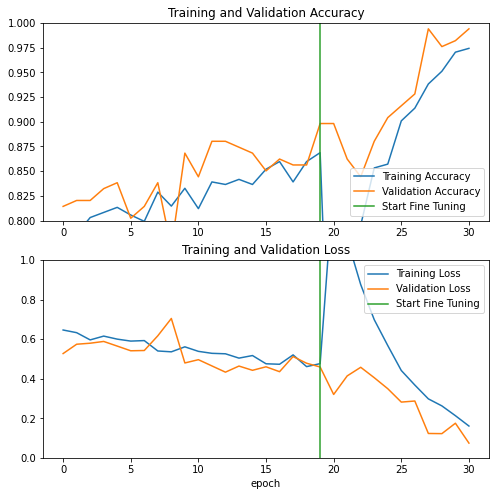

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Next steps to further improve accuracy


1.   Augment image dataset
2.   Tune image size
3.   Tune crop ratio for images
4.   Tune number of epochs and batches
5.   Tune learning rate
6.   Tune optimal layers to train when unfreezing model
7.   Average vs. Max pooling before fully-connected layer
8.   Look at accuracy per class - does the model have trouble with particular diseases?

